In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
import xscale as xsc
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.78:37998 Dashboard: http://10.148.0.78:8787/status,Cluster Workers: 31 Cores: 31 Memory: 495.07 GiB


_________
# 1. Read dataset


In [7]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

out_dir_store = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir_store+'mld_filter.zarr')

ds_filter = xr.merge([ds_W_lowpass,ds_B_lowpass,ds_MLD,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC            (lat, lon) float32 ...
    YC            (lat, lon) float32 ...
    ...            ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
  * lat_g         (lat_g) float32 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon_g         (lon_g) float32 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
Data variables:
    W_low_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    B_low_fil

In [11]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [13]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [14]:
lat = ds_filter['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

# 2.  vertical buoyancy flux w'b'

In [15]:
w_mean = ds_filter.W_low_filter.mean(['lat','lon']) # spatial mean
b_mean = ds_filter.B_low_filter.mean(['lat','lon'])
w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean

wb_spatial_prime_filter = (w_prime*b_prime)#.mean(['lat','lon'])

store_dir_zarr = '/home1/scratch/xyu/Energtics/'

chunks = {'time': 9415, 'depth':1, 'lat':1, 'lon':177}
wb_spatial_prime_filter = wb_spatial_prime_filter.chunk(chunks)
wb_spatial_prime_filter = np.real(wb_spatial_prime_filter).rename('wb_spatial_prime_filter')
wb_spatial_prime_filter = wb_spatial_prime_filter.drop(['XC','YC','CS','SN','Depth','rA'])
print(wb_spatial_prime_filter)
file_out = store_dir_zarr+'/wb_spatial_prime_filter.zarr'
%time wb_spatial_prime_filter.to_dataset().to_zarr(file_out, mode='w')   

<xarray.DataArray 'wb_spatial_prime_filter' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
CPU times: user 3min 4s, sys: 6.06 s, total: 3min 10s
Wall time: 4min 37s


In [16]:
w_mean = ds_filter.W_low_filter.mean(['time']) # time mean
b_mean = ds_filter.B_low_filter.mean(['time'])

w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean

wb_time_prime_filter = (w_prime*b_prime)

store_dir_zarr = '/home1/scratch/xyu/Energtics/'

chunks = {'time': 9415, 'depth':1, 'lat':1, 'lon':177}
wb_time_prime_filter = wb_time_prime_filter.chunk(chunks)
wb_time_prime_filter = np.real(wb_time_prime_filter).rename('wb_time_prime_filter')
wb_time_prime_filter = wb_time_prime_filter.drop(['XC','YC','CS','SN','Depth','rA'])
print(wb_time_prime_filter)
file_out = store_dir_zarr+'/wb_time_prime_filter.zarr'
%time wb_time_prime_filter.to_dataset().to_zarr(file_out, mode='w')   

<xarray.DataArray 'wb_time_prime_filter' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
CPU times: user 2min 12s, sys: 5.06 s, total: 2min 17s
Wall time: 2min 59s


In [17]:
# 1-month mean 
depth_all = range(52)

time_length = 30*24
store_dir_zarr = '/home1/scratch/xyu/Energtics/'

for depth in depth_all:

    wt_W = ds_filter.W_low_filter.isel(depth=depth).window
    wt_W.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon':177,'time': 9415})
    w_mean = wt_W.convolve()

    wt_B = ds_filter.B_low_filter.isel(depth=depth).window
    wt_B.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon':177,'time': 9415})
    b_mean = wt_B.convolve()

    w_prime = ds_filter.W_low_filter.isel(depth=depth) - w_mean
    b_prime = ds_filter.B_low_filter.isel(depth=depth) - b_mean
    wb_time_prime_filter = (w_prime*b_prime)
    chunks = {'lat': 1, 'lon': 177, 'time':9415}
    wb_time_prime_filter = wb_time_prime_filter.chunk(chunks)
    wb_time_prime_filter = np.real(wb_time_prime_filter).rename('wb_time_prime_filter')
    wb_time_prime_filter = wb_time_prime_filter.drop(['XC','YC','CS','SN','Depth','rA'])
    file_out = store_dir_zarr+'/wb_1month_prime_filter_d%02d.zarr'%(depth)
    wb_time_prime_filter.to_dataset().to_zarr(file_out, mode='w')   
    print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [21]:
# 10-day mean 
depth_all = range(52)

time_length = 10*24
store_dir_zarr = '/home1/scratch/xyu/Energtics/'

for depth in depth_all:

    wt_W = ds_filter.W_low_filter.isel(depth=depth).window
    wt_W.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon':177,'time': 9415})
    w_mean = wt_W.convolve()

    wt_B = ds_filter.B_low_filter.isel(depth=depth).window
    wt_B.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon':177,'time': 9415})
    b_mean = wt_B.convolve()

    w_prime = ds_filter.W_low_filter.isel(depth=depth) - w_mean
    b_prime = ds_filter.B_low_filter.isel(depth=depth) - b_mean
    wb_time_prime_filter = (w_prime*b_prime)
    chunks = {'lat': 1, 'lon': 177, 'time':9415}
    wb_time_prime_filter = wb_time_prime_filter.chunk(chunks)
    wb_time_prime_filter = np.real(wb_time_prime_filter).rename('wb_time_prime_filter')
    wb_time_prime_filter = wb_time_prime_filter.drop(['XC','YC','CS','SN','Depth','rA'])
    file_out = store_dir_zarr+'/wb_10day_prime_filter_d%02d.zarr'%(depth)
    wb_time_prime_filter.to_dataset().to_zarr(file_out, mode='w')   
    print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)
NoneType: None


depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready processed
depth=34 - allready processed
depth=35 - allready processed
depth=36 - allready processed
depth=37 - allready processed
depth=38 - allready processed
depth=39 - allready processed
depth=40 - allready processed
depth=41 - allready processed
depth=42 - allready processed
depth=43 - allready processed
depth=44 - allready processed
depth=45 - allready processed
depth=46 - allready processed


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-50e54f77d44c0408bb8065f3a3b6714e', 0, 0, 0)
NoneType: None


depth=47 - allready processed
depth=48 - allready processed
depth=49 - allready processed
depth=50 - allready processed
depth=51 - allready processed


## Read w'b'

In [22]:
out_dir_store = '/home1/scratch/xyu/Energtics/'

D = [xr.open_zarr(out_dir_store+'wb_1month_prime_filter_d%02d.zarr'%(depth)) for depth in range(52)]
wb_1month_prime_filter = xr.concat(D, dim='depth')
wb_1month_prime_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [23]:
out_dir_store = '/home1/scratch/xyu/Energtics/'

D = [xr.open_zarr(out_dir_store+'wb_10day_prime_filter_d%02d.zarr'%(depth)) for depth in range(52)]
wb_10day_prime_filter = xr.concat(D, dim='depth')
wb_10day_prime_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [27]:
store_dir_zarr = '/home1/scratch/xyu/Energtics/'
wb_spatial_prime_filter = xr.open_zarr(store_dir_zarr+'wb_spatial_prime_filter.zarr')
wb_time_prime_filter = xr.open_zarr(store_dir_zarr+'wb_time_prime_filter.zarr')

ds_wb = xr.merge([wb_spatial_prime_filter,
                  wb_time_prime_filter,
                  wb_1month_prime_filter.wb_time_prime_filter.rename('wb_1month'), 
                  wb_10day_prime_filter.wb_time_prime_filter.rename('wb_10day')
                 ])
ds_wb

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Text(0.5, 1.0, 'time')

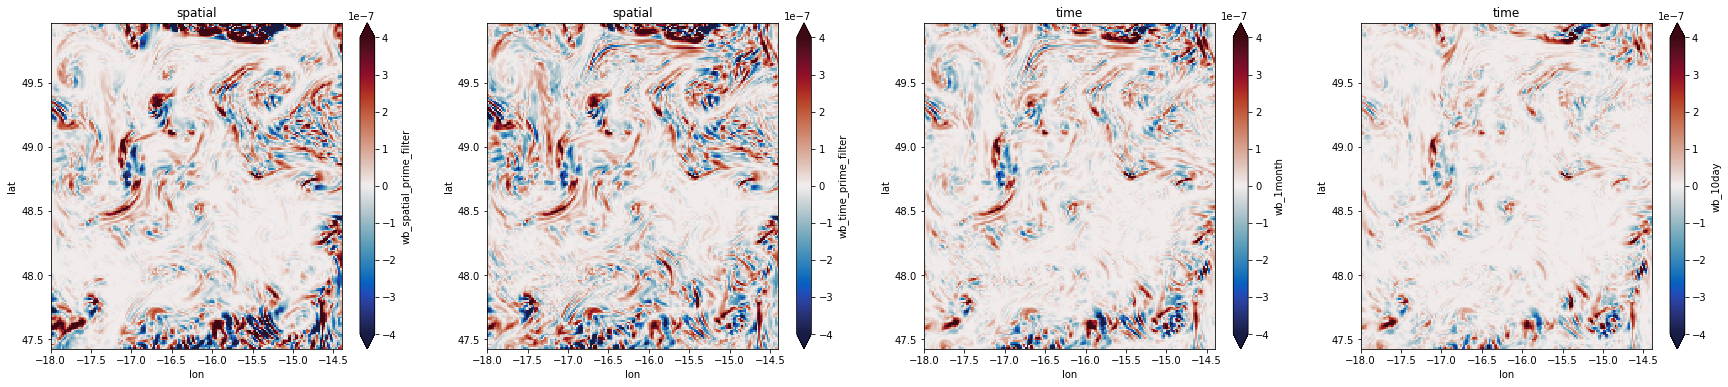

In [38]:
fig, ax = plt.subplots(figsize=(30,6))

ndepth = 30

ax = plt.subplot(141)
ds_wb.wb_spatial_prime_filter.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth).sel(time='2012-03-02T00:00:00').plot(x='lon', y='lat',vmin=-4e-7,vmax=4e-7,cmap=cm.balance, add_colorbar = True)
ax.set_title('spatial')

ax = plt.subplot(142)
ds_wb.wb_time_prime_filter.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth).sel(time='2012-03-02T00:00:00').plot(x='lon', y='lat',vmin=-4e-7,vmax=4e-7,cmap=cm.balance, add_colorbar = True)
ax.set_title('spatial')

ax = plt.subplot(143)
ds_wb.wb_1month.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth).sel(time='2012-03-02T00:00:00').plot(x='lon', y='lat',vmin=-4e-7,vmax=4e-7,cmap=cm.balance, add_colorbar = True)
ax.set_title('time')

ax = plt.subplot(144)
ds_wb.wb_10day.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth).sel(time='2012-03-02T00:00:00').plot(x='lon', y='lat',vmin=-4e-7,vmax=4e-7,cmap=cm.balance, add_colorbar = True)
ax.set_title('time')

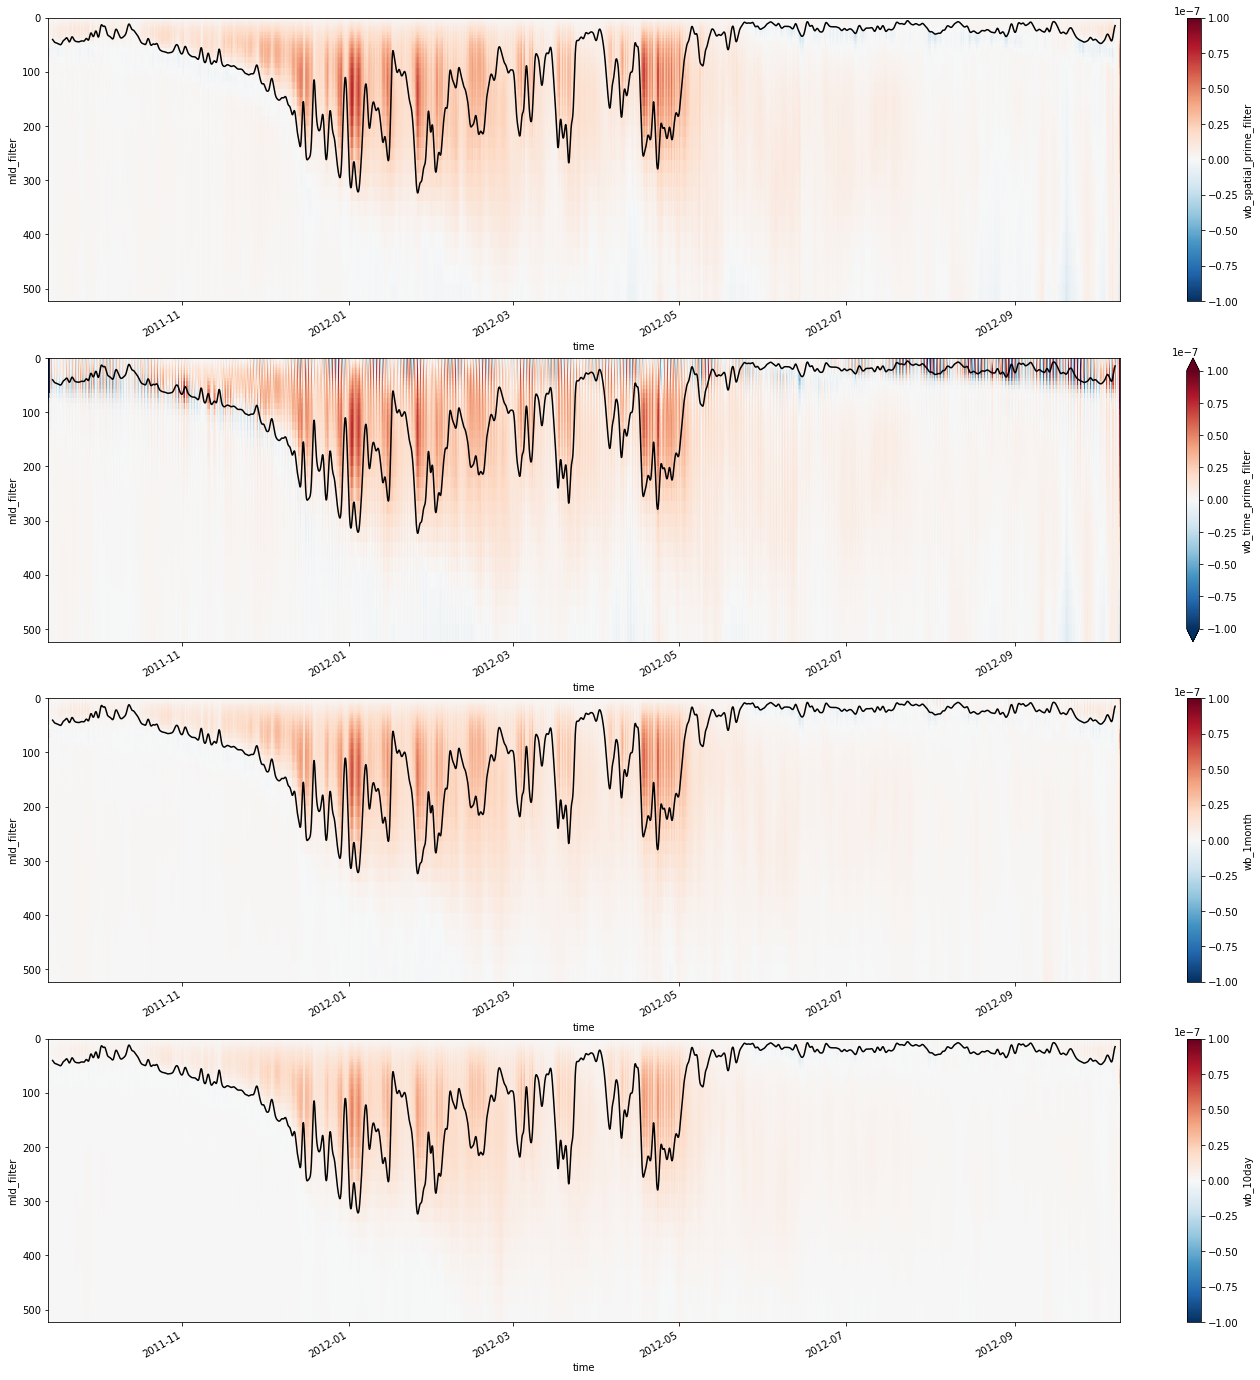

In [35]:
fig = plt.figure(figsize=(24,24))

plt.subplot(411)
ds_wb.wb_spatial_prime_filter.isel(depth=slice(0,40)).mean(['lat','lon']).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds_filter.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

plt.subplot(412)
ds_wb.wb_time_prime_filter.isel(depth=slice(0,40)).mean(['lat','lon']).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds_filter.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

plt.subplot(413)
ds_wb.wb_1month.isel(depth=slice(0,40)).mean(['lat','lon']).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds_filter.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

plt.subplot(414)
ds_wb.wb_10day.isel(depth=slice(0,40)).mean(['lat','lon']).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds_filter.mld_filter.mean(['lat','lon']).plot(x='time',color='black', yincrease=False)

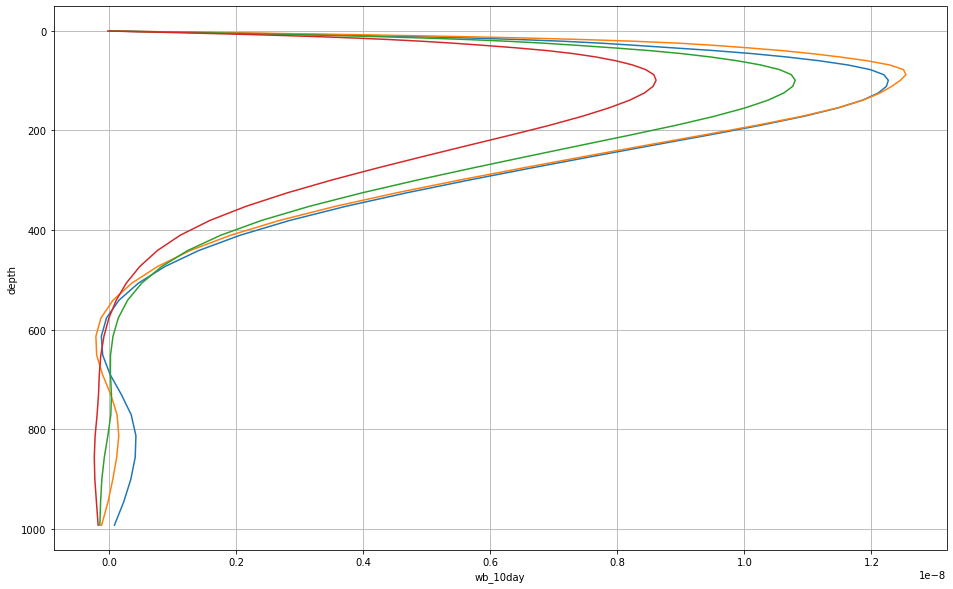

In [36]:
fig, ax = plt.subplots(figsize=(16,10))

ds_wb.wb_spatial_prime_filter.isel(time=slice(24,-24)).mean(['lat','lon','time']).plot(y='depth', yincrease=False)
ds_wb.wb_time_prime_filter.isel(time=slice(24,-24)).mean(['lat','lon','time']).plot(y='depth', yincrease=False)
ds_wb.wb_1month.isel(time=slice(24,-24)).mean(['lat','lon','time']).plot(y='depth', yincrease=False)
ds_wb.wb_10day.isel(time=slice(24,-24)).mean(['lat','lon','time']).plot(y='depth', yincrease=False)
ax.grid()

In [19]:
cluster.close()